In [3]:
import numpy as np
import torch
import torchvision
from torch import nn
from tqdm import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Load the data
train_data = torchvision.datasets.MNIST(root='/data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

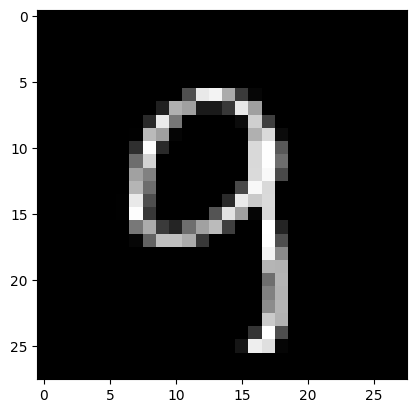

In [5]:
# Visualize the data
images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')

In [6]:
class DigitRecognizer(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.model = nn.Sequential(nn.Linear(784, 500),
                                        nn.ReLU(),
                                        nn.Linear(500, 100),
                                        nn.ReLU(),
                                        nn.Linear(100, 10))

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        with torch.no_grad():
            return torch.argmax(self.forward(x), dim=1)

In [7]:
model = DigitRecognizer()

In [8]:
summary(model, input_size=(1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
DigitRecognizer                          [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 500]                  392,500
│    └─ReLU: 2-2                         [1, 500]                  --
│    └─Linear: 2-3                       [1, 100]                  50,100
│    └─ReLU: 2-4                         [1, 100]                  --
│    └─Linear: 2-5                       [1, 10]                   1,010
Total params: 443,610
Trainable params: 443,610
Non-trainable params: 0
Total mult-adds (M): 0.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.77
Estimated Total Size (MB): 1.78

In [9]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Train the model
epochs = 5
model.to(device)
losses = []
for e in range(epochs):
    
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images.view(images.shape[0], -1))
        
        # Calculate the loss
        loss = loss_fn(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
        
    print(f"Training loss: {running_loss/len(train_loader)}")

Epoch 1/5: 100%|██████████| 938/938 [00:08<00:00, 105.75it/s]


Training loss: 0.2583577632288466


Epoch 2/5: 100%|██████████| 938/938 [00:10<00:00, 92.60it/s] 


Training loss: 0.09674318446599042


Epoch 3/5: 100%|██████████| 938/938 [00:09<00:00, 94.21it/s] 


Training loss: 0.06233397273144234


Epoch 4/5: 100%|██████████| 938/938 [00:10<00:00, 90.64it/s] 


Training loss: 0.04512631705689576


Epoch 5/5: 100%|██████████| 938/938 [00:10<00:00, 91.72it/s] 

Training loss: 0.034398931759605206


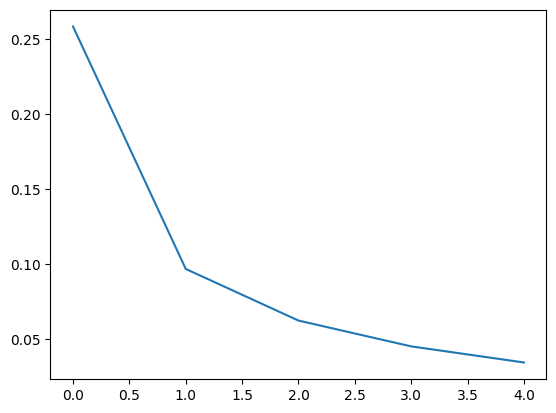

In [11]:
# Plot the losses
plt.plot(losses)

In [12]:
# Test the model

# Turn off gradients
with torch.no_grad():
        
        model.eval()
        
        total_correct = 0
        for images, labels in tqdm(test_loader):
            images, labels = images.to('cuda'), labels.to('cuda')
            # Flatten the images
            images = images
            
            # Forward pass
            output = model(images.view(images.shape[0], -1))
            
            # Get the predictions
            ps = torch.exp(output)
            
            # Get the top prediction
            top_p, top_class = ps.topk(1, dim=1)
            
            # Get the number of correct predictions
            equals = top_class == labels.view(*top_class.shape)
            
            # Sum the correct predictions
            total_correct += torch.sum(equals.type(torch.FloatTensor))
            
        else:
            print(f"Test accuracy: {100*total_correct.item()/len(test_loader.dataset)}%")

100%|██████████| 157/157 [00:01<00:00, 131.56it/s]

Test accuracy: 97.99%


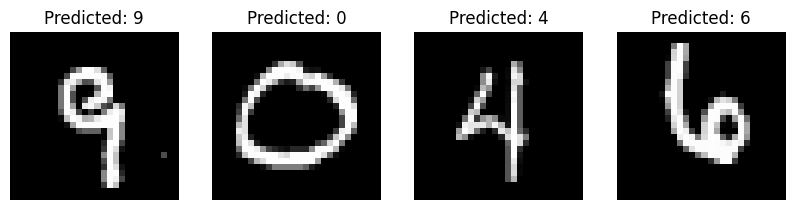

In [59]:
# Compare the predictions with the images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
# Flatten the images
images = images.view(images.shape[0], -1)

# Forward pass
output_label = model.predict(images)

# Plot the images
fig, axes = plt.subplots(figsize=(10, 4), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(images[i].view(28, 28).cpu(), cmap='gray')
    ax.set_title(f"Predicted: {output_label[i].item()}")
    ax.axis('off')

In [14]:
# Save the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_mnist_FFN.pt"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)